#### Packages

In [208]:
import matplotlib.pyplot as plt
import statsmodels.api as sm
import statsmodels.formula.api as smf
import seaborn as sns
import pandas as pd
import numpy as np
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from sklearn.linear_model import LinearRegression
from sklearn.cluster import KMeans, DBSCAN
from sklearn.metrics import mutual_info_score
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KernelDensity
from scipy import stats
from scipy.stats import levene, f_oneway

#### Load File

In [ ]:
diff_file = r'C:/Users/mayda/Downloads/diff.csv'
df = pd.read_csv(diff_file)
df.drop(columns=df.columns[0], axis=1, inplace=True)

stud_data = r'C:/Users/mayda/Downloads/第三波(2005)高中職五專學生問卷資料/CSV/w3_sf_s_cpnp_lv7.0.csv'
df_stud = pd.read_csv(stud_data)
par_data = r"C:/Users/mayda/Downloads/第三波(2005)高中職五專家長問卷資料/w3_sf_p_cpnp_lv7.0.csv"
df_par = pd.read_csv(par_data)
future_data = r"C:/Users/mayda/Downloads/2005年高中職五專學生核心樣本2019年調查/cp2019.csv"
df_future = pd.read_csv(future_data)

##### Data Pre-processing

In [210]:
df = df.merge(df_stud[['stud_id', 'w3s303', 'w3s344', 'w3s478']], on='stud_id', how='outer')
df = df.merge(df_par[['stud_id', 'w3p103', 'w3p104', 'w3p107', 'w3p108', 'w3p109', 'w3p110', 
                      'w3p205', 'w3p206', 
                      'w3p301', 'w3p302', 'w3p303', 'w3p307', 'w3p308', 'w3p312', 'w3p313', 'w3p315', 
                      'w3p502', 'w3p505', 'w3p513', 'w3p528', 'w3p531', 'w3p534', 
                      'w3p601', 'w3p602']], on='stud_id', how='outer')
df = df.merge(df_future[['stud_id', 'cp19v66', 'cp19v66_k', 'cp19v78_x']], on='stud_id', how='outer')
df['cp'] = [0 if x >= 30002 else 1 for x in df['stud_id']] # cp=1: 追蹤樣本
df

,stud_id,diff1,diff2,diff3,diff4,diff5,diff6,diff7,diff8,diff9,...,w3p513,w3p528,w3p531,w3p534,w3p601,w3p602,cp19v66,cp19v66_k,cp19v78_x,cp
0,2,0.0,1.0,2.0,0.0,1.0,1.0,1.0,1.0,1.0,...,3.0,,,,1.0,3.0,9.0,,5.0,1
1,3,0.0,0.0,2.0,1.0,2.0,1.0,NaN,NaN,0.0,...,2.0,,,,2.0,5.0,96.0,,96.0,1
2,4,0.0,1.0,2.0,1.0,0.0,0.0,3.0,2.0,1.0,...,1.0,,,,1.0,6.0,17.0,,96.0,1
3,10,0.0,NaN,1.0,1.0,0.0,0.0,0.0,0.0,0.0,...,2.0,,,,1.0,4.0,96.0,,96.0,1
4,12,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,...,2.0,,,,2.0,4.0,96.0,,96.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20131,50128,1.0,1.0,2.0,2.0,1.0,0.0,0.0,1.0,0.0,...,3.0,3,1,2,1.0,3.0,NaN,NaN,NaN,0
20132,50131,1.0,0.0,0.0,2.0,1.0,0.0,1.0,2.0,0.0,...,2.0,1,1,2,2.0,1.0,NaN,NaN,NaN,0
20133,50132,3.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,...,2.0,1,2,2,1.0,4.0,NaN,NaN,NaN,0
20134,50134,2.0,0.0,3.0,2.0,1.0,0.0,0.0,1.0,0.0,...,2.0,1,1,2,2.0,5.0,NaN,NaN,NaN,0


In [211]:
# # w3p602 您家裡平均每個月的總收入是多少？
# df.loc[df['w3p602'] == 1.0, 'w3p602'] = 10000
# df.loc[df['w3p602'] == 2.0, 'w3p602'] = 25000
# df.loc[df['w3p602'] == 3.0, 'w3p602'] = 40000
# df.loc[df['w3p602'] == 4.0, 'w3p602'] = 75000
# df.loc[df['w3p602'] == 5.0, 'w3p602'] = 150000
# df.loc[df['w3p602'] == 6.0, 'w3p602'] = 250000

##### 變數們

In [212]:
# 家長小孩之間的認知落差
diff_columns = ['diff1', 'diff2', 'diff3', 'diff4', 'diff5', 'diff6', 'diff7', 'diff8', 'diff9', 'diff10', 'diff11', 'diff12']
# 家庭背景
# family_vars = ['w3s303', 'w3s344', 'w3p103', 'w3p104', 'w3p107', 'w3p108', 'w3p109', 'w3p110', 'w3p601', 'w3p602']
family_vars = ['w3s344', 'w3p103', 'w3p104', 'w3p107', 'w3p602']
all_vars = family_vars + ['diff_avg']

# 家長主動程度
act_vars = ['w3p312', 'w3p313', 'w3p502', 'w3p505'] 
happy = ['w3s478'] # 小孩快樂嗎?
total_vars = act_vars + ['diff_avg'] + happy

# 教養腳本
blue_vars = ['w3p104', 'w3p602', 'w3p205', 'w3p206', 'w3p301', 'w3p302' ,'stud_id', 'diff_avg',
             'w3p303', 'w3p307', 'w3p308', 'w3p315', 'w3p513', 'w3p528', 'w3p531', 'w3p534', 'w3s478']

In [ ]:
m = df.cp==1
old_df=df[m] # 追蹤樣本
new_df=df[~m] # 新樣本

# old_df = old_df.drop(old_df.columns[[13, 14, 15, 16, 17, 18, 19, 20, 21, 22]], axis=1)
old_df['stud_id'] = old_df['stud_id'].astype(str)
old_df['diff_avg'] = old_df[diff_columns].mean(axis=1).round(4)

new_df['stud_id'] = new_df['stud_id'].astype(str)
new_df['diff_avg'] = new_df[diff_columns].mean(axis=1).round(4)

#### 藍佩嘉: 階級教養腳本

In [214]:
df_blue = new_df[blue_vars].copy()

education_level_mapping = {1: '國中或以下', 2: '高中', 3: '高職', 4: '專科或科大', 5: '一般大學', 6: '研究所'}
income_level_mapping = {1: '2萬以下', 2: '2~3萬', 3: '3~5萬', 4: '5~10萬', 5: '10~20萬', 6: '20萬以上'}
df_blue['w3p104_label'] = df_blue['w3p104'].map(education_level_mapping)
df_blue['w3p602_label'] = df_blue['w3p602'].map(income_level_mapping)

# Convert the columns to categorical data types with the correct order
education_order = ['國中或以下', '高中', '高職', '專科或科大', '一般大學', '研究所']
income_order = ['2萬以下', '2~3萬', '3~5萬', '5~10萬', '10~20萬', '20萬以上']

df_blue['w3p104_label'] = pd.Categorical(df_blue['w3p104_label'], categories=education_order, ordered=True)
df_blue['w3p602_label'] = pd.Categorical(df_blue['w3p602_label'], categories=income_order, ordered=True)

# Aggregate the data to count occurrences of each combination
agg_df = df_blue.groupby(['w3p104_label', 'w3p602_label']).size().reset_index(name='count')

# Plot using Plotly Express
fig = px.scatter(
    agg_df,
    x='w3p104_label',
    y='w3p602_label',
    size='count',
    size_max=60,
    title='Scatter Plot of Education Level vs Income Level by stud_id',
    labels={'w3p104_label': 'Education Level', 'w3p602_label': '家庭平均每個月的總收入'},
    template='plotly_white'
)

# Show the plot
fig.show()

##### 四個組別顯形!

In [215]:
# Define family types based on education and income levels
def classify_family_type(row):
    if row['w3p104'] >= 4 and row['w3p602'] >= 4:
        return 'High Edu High Income'
    elif row['w3p104'] >= 4 and row['w3p602'] < 4:
        return 'High Edu Low Income'
    elif row['w3p104'] < 4 and row['w3p602'] < 4:
        return 'Low Edu Low Income'
    elif row['w3p104'] < 4 and row['w3p602'] >= 4:
        return 'Low Edu High Income'
    else:
        return 'Other'

# Apply the classification
df_blue['family_type'] = df_blue.apply(classify_family_type, axis=1)
print(df_blue['family_type'].value_counts())
df_blue_cleaned = df_blue.dropna(subset=blue_vars + ['family_type'])

Low Edu Low Income      7118
Low Edu High Income     4388
High Edu High Income    2908
High Edu Low Income      939
Other                    522
Name: family_type, dtype: int64


In [216]:
anova_results = {}
for var in blue_vars:
    grouped_data = [group[var].dropna() for name, group in df_blue_cleaned.groupby('family_type')]
    f_val, p_val = f_oneway(*grouped_data)
    anova_results[var] = {'F-value': f_val, 'P-value': p_val}

# Display the results
anova_df = pd.DataFrame(anova_results).T
anova_df = anova_df.sort_values(by='P-value')
print(anova_df.round(4))

           F-value  P-value
w3p104    977.3867   0.0000
w3p602    218.6297   0.0000
w3p205     89.9449   0.0000
w3p531     33.2500   0.0000
w3p301     27.0581   0.0000
w3p302     25.6279   0.0000
w3p206     14.0315   0.0000
w3p534     13.2901   0.0000
w3p528      8.2129   0.0000
w3p308      7.2708   0.0001
w3p303      6.5280   0.0002
w3p307      4.2465   0.0052
diff_avg    1.5970   0.1878
w3s478      1.3011   0.2722
w3p513      1.1198   0.3395
w3p315      0.7520   0.5210
stud_id     0.7149   0.5430


In [217]:
# cram_level_mapping = {1: '沒有補習', 2: '1千元以下', 3: '1~2千元', 4: '2~3千元', 5: '3~4千元', 6: '4千元以上'}
# df_blue['w3p205_label'] = df_blue['w3p205'].map(cram_level_mapping)
# cram_order = ['沒有補習', '1千元以下', '1~2千元', '2~3千元', '3~4千元', '4千元以上']
# df_blue['w3p205_label'] = pd.Categorical(df_blue['w3p205_label'], categories=cram_order, ordered=True)
cram_level_mapping = {1: '沒有補習', 2: '有補習', 3: '有補習', 4: '有補習', 5: '有補習', 6: '有補習'}
df_blue['w3p205_label'] = df_blue['w3p205'].map(cram_level_mapping)
cram_order = ['沒有補習', '有補習']
df_blue['w3p205_label'] = pd.Categorical(df_blue['w3p205_label'], categories=cram_order, ordered=True)

art_level_mapping = {1: '沒有才藝班', 2: '有才藝班', 3: '有才藝班', 4: '有才藝班', 5: '有才藝班', 6: '有才藝班'}
df_blue['w3p206_label'] = df_blue['w3p206'].map(art_level_mapping)
art_order = ['沒有才藝班', '有才藝班']
df_blue['w3p206_label'] = pd.Categorical(df_blue['w3p206_label'], categories=art_order, ordered=True)

happy_level_mapping = {1: '非常快樂', 2: '還算快樂', 3: '不太快樂', 4: '非常不快樂'}
df_blue['w3s478_label'] = df_blue['w3s478'].map(happy_level_mapping)
happy_order = ['非常不快樂', '不太快樂', '還算快樂', '非常快樂']
df_blue['w3s478_label'] = pd.Categorical(df_blue['w3s478_label'], categories=happy_order, ordered=True)

In [218]:
# Aggregate the data to count occurrences of each combination
agg_df = df_blue.groupby(['w3p104_label', 'w3p602_label', 'w3p206_label']).size().reset_index(name='count')

# Plot using Plotly Express
fig = px.scatter(
    agg_df,
    x='w3p104_label',
    y='w3p602_label',
    size='count',
    color='w3p206_label',
    size_max=60,
    title='Scatter Plot of Education Level vs Income Level by stud_id',
    labels={'w3p104_label': '家長教育程度', 'w3p602_label': '家庭總收入(每月平均)', 'w3p205_label': '才藝班'},
    template='plotly_white'
)

# Show the plot
fig.show()

In [219]:
# Aggregate the data to count occurrences of each combination
agg_df = df_blue.groupby(['w3p104_label', 'w3p602_label', 'w3s478_label']).size().reset_index(name='count')

# Plot using Plotly Express
fig = px.scatter(
    agg_df,
    x='w3p104_label',
    y='w3p602_label',
    size='count',
    color='w3s478_label',
    size_max=60,
    title='Scatter Plot of Education Level vs Income Level by stud_id',
    labels={'w3p104_label': '家長教育程度', 'w3p602_label': '家庭總收入(每月平均)', 'w3s478_label': '快樂程度(自評)'},
    template='plotly_white'
)

# Show the plot
fig.show()

In [220]:
df_blue['w3p104_label'] = df_blue['w3p104'].map(education_level_mapping)
df_blue['w3p602_label'] = df_blue['w3p602'].map(income_level_mapping)    
df_blue['w3p104_label'] = pd.Categorical(df_blue['w3p104_label'], categories=education_order, ordered=True)
df_blue['w3p602_label'] = pd.Categorical(df_blue['w3p602_label'], categories=income_order, ordered=True)

# Get the total number of students
total_students = df_blue['stud_id'].nunique()

percentile_20 = df_blue['diff_avg'].quantile(0.2)
percentile_80 = df_blue['diff_avg'].quantile(0.8)
def map_know_level(diff_avg):
  if diff_avg <= percentile_20:
    return 1
  elif diff_avg > percentile_80:
    return 3
  else:
    return 2
df_blue['know_level'] = df_blue['diff_avg'].apply(map_know_level)

know_level_mapping = {1: '認知落差小', 2: '普通', 3: '認知落差大'}
df_blue['know_level_label'] = df_blue['know_level'].map(know_level_mapping)
know_order = ['認知落差小', '普通', '認知落差大']
df_blue['know_level_label'] = pd.Categorical(df_blue['know_level_label'], categories=know_order, ordered=True)

# Aggregate the data to count occurrences of each combination
agg_df = df_blue.groupby(['w3p104_label', 'w3p602_label', 'know_level_label']).size().reset_index(name='count')

# Plot using Plotly Express
fig = px.scatter(
    agg_df,
    x='w3p104_label',
    y='w3p602_label',
    size='count',
    color='know_level_label',
    size_max=60,
    title='Scatter Plot of Education Level vs Income Level by Knowledge Level',
    labels={'w3p104_label': 'Education Level', 'w3p602_label': '家庭總收入(每月平均)', 'know_level_label': '親子間認知程度'},
    template='seaborn'
)

# Show the plot
fig.show()

In [221]:
# Aggregate the data to count occurrences of each combination
agg_df = df_blue.groupby(['w3s478_label', 'w3p602_label', 'know_level_label']).size().reset_index(name='count')

# Plot using Plotly Express
fig = px.scatter(
    agg_df,
    x='w3s478_label',
    y='w3p602_label',
    size='count',
    color='know_level_label',
    size_max=60,
    title='Scatter Plot of 快樂程度(自評) vs 家庭總收入(每月平均) by 親子間認知程度',
    labels={'w3s478_label': '快樂程度(自評)', 'w3p602_label': '家庭總收入(每月平均)', 'know_level_label': '親子間認知程度'},
    template='seaborn'
)

# Show the plot
fig.show()

#### 主動的家長

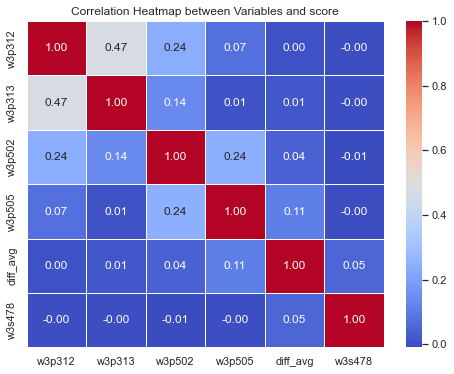

In [222]:
correlation_matrix = old_df[total_vars].corr()

# Plotting the heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title('Correlation Heatmap between Variables and score')
plt.show()

#### 依照互相認知分數分群

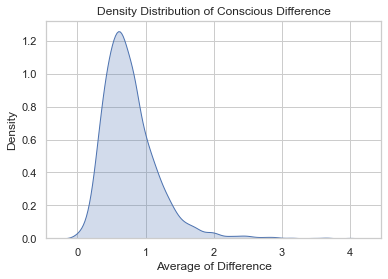

In [223]:
# Plot density distribution of ESG score
sns.set(style="whitegrid")
plt.figure(figsize=(6, 4))
sns.kdeplot(old_df['diff_avg'], fill=True, color="b")
plt.title('Density Distribution of Conscious Difference')
plt.xlabel('Average of Difference')
plt.ylabel('Density')
plt.show()

In [ ]:
quantile_20 = old_df['diff_avg'].quantile(0.20)
quantile_80 = old_df['diff_avg'].quantile(0.80)

# Create the 'knowwell' and 'knowpoor' columns
old_df['knowwell'] = (old_df['diff_avg'] <= quantile_20).astype(int)
old_df['knowpoor'] = (old_df['diff_avg'] >= quantile_80).astype(int)

##### 很了解子女

In [225]:
w = old_df.knowwell==1
df_well = old_df[w]

In [226]:
stat_summary = df_well[all_vars].describe()
print(stat_summary)

           w3s344      w3p103      w3p104      w3p107      w3p602    diff_avg
count  879.000000  879.000000  879.000000  879.000000  879.000000  879.000000
mean     4.230944    1.224118    2.646189    1.502844    3.771331    0.341294
std     14.480767    0.673995    1.354552    0.671366    6.533167    0.095494
min      1.000000    1.000000    1.000000    1.000000    1.000000    0.000000
25%      1.000000    1.000000    1.000000    1.000000    3.000000    0.272700
50%      2.000000    1.000000    3.000000    1.000000    3.000000    0.333300
75%      2.000000    1.000000    3.000000    2.000000    4.000000    0.416700
max     99.000000    5.000000    6.000000    4.000000   99.000000    0.454500


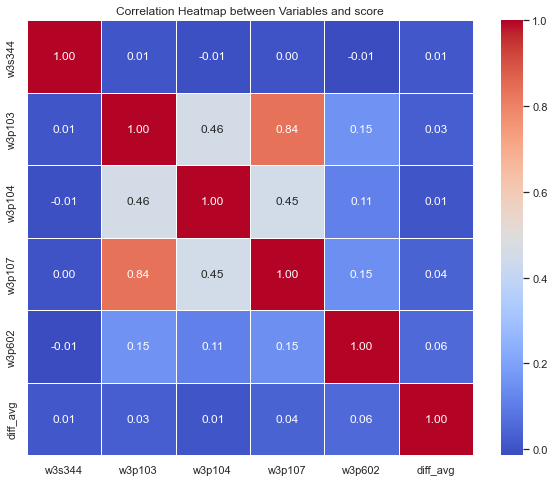

In [227]:
correlation_matrix = old_df[all_vars].corr()

# Plotting the heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title('Correlation Heatmap between Variables and score')
plt.show()

In [228]:
# Define the dependent variable
dependent_var = 'diff_avg'

# Create the formula for the regression model
formula = f"{dependent_var} ~ " + " + ".join(family_vars)

# Fit the regression model
model = smf.ols(formula=formula, data=old_df).fit()

# Print the summary of the regression analysis
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:               diff_avg   R-squared:                       0.005
Model:                            OLS   Adj. R-squared:                  0.003
Method:                 Least Squares   F-statistic:                     3.783
Date:                Mon, 20 May 2024   Prob (F-statistic):            0.00203
Time:                        17:25:39   Log-Likelihood:                -2216.6
No. Observations:                4170   AIC:                             4445.
Df Residuals:                    4164   BIC:                             4483.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.7493      0.010     74.331      0.0

##### 認知程度和未來發展(薪水)

In [ ]:
salary_mapping = {1: 0, 2: 5000, 3: 12500, 4: 17500, 5: 22500, 
                  6: 27500, 7: 32500, 8: 37500, 9: 42500, 10: 47500, 
                  11: 52500, 12: 57500, 13: 62500, 14: 67500, 15: 72500, 
                  16: 77500, 17: 82500, 18: 87500, 19: 92500, 20: 97500}

old_df['cp19v66_k'] = old_df['cp19v66'].apply(lambda x: salary_mapping.get(x, np.nan))
nan_count = old_df['cp19v66_k'].isna().sum() # 2480
not_nan_count = (~old_df['cp19v66_k'].isna()).sum() #1781

In [236]:
if pd.api.types.is_numeric_dtype(old_df['cp19v66_k']) and pd.api.types.is_numeric_dtype(old_df['diff_avg']):
  # Calculate Pearson correlation coefficient
  correlation = old_df['cp19v66_k'].corr(old_df['diff_avg'])
  print("Correlation coefficient between 'cp19v66_k' and 'diff_avg':", correlation)


Correlation coefficient between 'cp19v66_k' and 'diff_avg': 0.025273610261366732
